In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy import linalg

In [2]:
# function [R t, a] = gPPnP(P,O,S,tol,pz)
# from A. Fusiello, F. Crosilla, and F. Malapelle, “Procrustean point-line 
# registration and the NPnP problem,” in 2015 International Conference on 
# 3D Vision, Oct. 2015, pp. 250–255. doi: 10.1109/3DV.2015.35.
def gPPnP(P, O, S, tol, pz = True, unit_scale=True):
    """
    input
        P : matrix (nx3) of line versors
        O : matrix (nx3) of line origins
        S : matrix (nx3) 3D coordinates
        tol: exit tolerance
        pZ : positive Z flag
        unit_scale : whether or not to compute the scale factor
    output
        T: Euclidean transform from frame of P and O to frame of S
        iter: number of iterations to reach tolernce
    """
    n = P.shape[0]
    #print(P.shape, O.shape, S.shape)
    Z = np.diag(np.ones(n)) #Z is n x n
    II = np.identity(n) - np.full((n,n), 1.0/n) # II is n x n
    err = np.inf
    E_old = 1000 * np.ones((n, 3))   # E_old is n x 3
    D = linalg.khatri_rao(np.identity(n), P.T)   # D is 3n x n
    iter = 0
    while err > tol:
        iter += 1
        U, _, Vt = np.linalg.svd((Z @ P + O).T @ II @ S)  # (Z @ P + O).T @ II @ S is 3 x 3, U and Vt are 3 x 3
        R = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt  # R is 3 x 3
        A = Z @ P + O    # A is n x 3
        AR = A @ R  # AR is n x 3
        if unit_scale:
            a = 1
        else:
            a = np.trace(A.T @ II @ A) / np.trace(AR.T @ II @ S)  # A.T @ II @ A is 3 x 3, AR.T @ II @ S is 3 x 3
        
        c = np.mean(a * S - AR, axis = 0, keepdims=True).T # c is 3 x 1
        X = a * S - O @ R - np.ones((n,1)) @ c.T      # X is n x 3
        vecY = (R @ X.T).reshape((-1,1), order="F")   # R @ X.T is 3 x n, vecY is 3n x 1
        v, _, _, _ = np.linalg.lstsq(D, vecY, rcond=None) # v is n by 1
        if pz:
            v[v<0] = 0

        # print("v shape is ", v.shape)
        Z = np.diag(v.reshape(-1)) # Z is n x n
        E = X - Z @ P @ R        # E is n x 3
        err = np.linalg.norm(E - E_old)
        E_old = E

    t = -R @ c
    
    return np.vstack((np.hstack((R.T, -R.T @ t)),
                      np.array([0,0,0,1]))), iter



   # function [R t, a] = gFiore(P,O,S)
def gFiore(P,O,S, unit_scale=True):
    """
    input
        P : matrix (nx3) of line versors
        O : matrix (nx3) of line origins
        S : matrix (nx3) 3D coordinates
        unit_scale : whether or not to compute the scale factor
    output
        T: Euclidean transform from frame of P and O to frame of S
    """
    n = P.shape[0]
    II = np.identity(n) - np.full((n,n), 1.0/n)
    M = np.concatenate((S, np.ones((n,1))), axis=1).T
    _, sv, Vt = np.linalg.svd(M)
    tol = sv.max() * max(M.shape) * np.finfo(M.dtype).eps
    rankM = (sv > tol).sum()
    # print("rank M is ", rankM)
    Vrt = Vt[rankM:,:]
    # print("shape of Vrt is ", Vrt.shape)
    D = (P @ P.T) * (Vrt.T @ Vrt)
    # print("D is ", D)
    b = -np.diag((Vrt.T @ Vrt @ O @ P.T))
    # print("b is ", b)
    v, _, _, _ = np.linalg.lstsq(D, b, rcond=None)
    # print("v is ", v)
    Z = np.diag(v.reshape(-1))
    U, _, Vt = np.linalg.svd((Z @ P + O).T @ II @ S)
    R = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt
    A = Z @ P + O 
    AR = A @ R
    if unit_scale:
        a = 1 
    else:
        a = np.trace(A.T @ II @ A) / np.trace(AR.T @ II @ S)

    c = np.mean(a * S - AR, axis = 0, keepdims=True).T
    t = -R @ c
    
    return np.vstack((np.hstack((R.T, -R.T @ t)),
                      np.array([0,0,0,1])))


In [3]:
# test code
# create four camera array with cameras
# CT[i,:,:] is the transform from camera i to the generalized camera frame, whose origin is
# at the center of the four cameras with x to the left, y forward, and z up. The cameras are 
# numbered 0..3 counter-clockwise from the one pointing right and forward. The cameras are on 
# corners of a 60cmx10cm (x by y) rectangle in the z=0 plane centered at the origin. Distance
# units are meters.
CT = np.zeros((4, 4,4))
CT[0, 0:3,0:3] = (R.from_rotvec([-np.pi/2,0,0]) * R.from_rotvec([0,np.pi/4,0])).as_matrix()
CT[0, :,3] = [ 0.3,  0.05, 0, 1]
CT[1,0:3,0:3] = (R.from_rotvec([-np.pi/2,0,0]) * R.from_rotvec([0,-np.pi/4,0])).as_matrix()
CT[1, :,3] = [-0.3,  0.05, 0, 1]
CT[2,0:3,0:3] = (R.from_rotvec([-np.pi/2,0,0]) * R.from_rotvec([0,-3*np.pi/4,0])).as_matrix()
CT[2, :,3] = [-0.3, -0.05, 0, 1]
CT[3,0:3,0:3] = (R.from_rotvec([-np.pi/2,0,0]) * R.from_rotvec([0,3*np.pi/4,0])).as_matrix()
CT[3, :,3] = [ 0.3, -0.05, 0, 1]

# The april tags are at the 20 locations given in the 4x20 array A (in homogeneous coordinates)
A = np.array([10*[3] + 10*[-3],
              4*list(range(0,5)),
              2*(5*[0] + 5*[1]),
              20*[1]])

# The generalized camera starts out at the world cooridnate frame and moves along the world y axis
T = np.zeros((5, 4,4))
T[0, 0:3,0:3] = np.identity(3)
T[0, :,3] = [0, 0, 0, 1]
T[1, 0:3,0:3] = np.identity(3)
T[1, :,3] = [0, 1, 0, 1]
T[2, 0:3,0:3] = np.identity(3)
T[2, :,3] = [0, 2, 0, 1]
T[3, 0:3,0:3] = R.from_rotvec([0,0,np.pi/6]).as_matrix()
T[3, :,3] = [0, 2, 1, 1]
T[4, 0:3,0:3] = R.from_rotvec([0,0,np.pi/4]).as_matrix()
T[4, :,3] = [1, 2, 0, 1]

# Project features to produce P and O. Assume tags project into cameras 0-3 based on their x-y 
# quadrant in the generalized camera frame
def project(T, A):
    """
       T is the transform from the generalized camera to the world
       A is a 4 by n array with the homogeneous coordinates of the tags
       
       Returns:
       O: n by 3 array of the projection ray origins in the generalized camera frame
       P: n by 3 array of the projection ray directions (to the tags) in the generalized camera frame
    """
    signs2camera= [[2, 1], [3, 0]]
    n = A.shape[1]
    G = np.linalg.inv(T) @ A   # tags in generalized camera frame
    O = np.zeros((n,3))
    P = np.zeros((n,3))
    for p in range(n):
        camera = signs2camera[int(G[0,p] >= 0)][int(G[1,p] >= 0)]
        O[p,:] = CT[camera, 0:3, 3]
        # transform the tag in generalized camera coords to the real camera coords, then
        # rotate this direction back to generalized camera coords again and normalize to unit length
        P[p,:] = CT[camera, 0:3,0:3] @ (np.linalg.inv(CT[camera, :,:]) @ G[:, p])[0:3]
        P[p,:] /= np.linalg.norm(P[p,:])
        
    return P, O
    
# test
A_s = A[:, 0::6]
print(A_s.shape)
P,O = project(T[4,:,:], A_s)
#print("P is ", np.round(P, 3))
#print("O is ", np.round(O, 3))
T_i, itr = gPPnP(P, O, A_s[0:3,:].T, tol=(0.0001**2)*np.prod(A_s.shape))
print("T_i is\n", np.round(T_i, 3))
print("gPPnP used ", itr, " iterations")
T_s = gFiore(P, O, A_s[0:3,:].T)
print("T_s is\n", np.round(T_s, 3))


(4, 4)
T_i is
 [[ 0.707 -0.707  0.     1.   ]
 [ 0.707  0.707  0.     2.   ]
 [-0.    -0.     1.    -0.   ]
 [ 0.     0.     0.     1.   ]]
gPPnP used  289  iterations
T_s is
 [[ 0.969 -0.086  0.23   0.361]
 [-0.224 -0.693  0.685  1.684]
 [ 0.1   -0.716 -0.691  0.801]
 [ 0.     0.     0.     1.   ]]


In [4]:
T[4,:,:]


array([[ 0.70710678, -0.70710678,  0.        ,  1.        ],
       [ 0.70710678,  0.70710678,  0.        ,  2.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

[[ 0.2   -0.    -0.     1.177]
 [ 0.     0.     0.2    2.247]
 [-0.    -0.2    0.     0.   ]
 [ 0.     0.     0.     1.   ]]


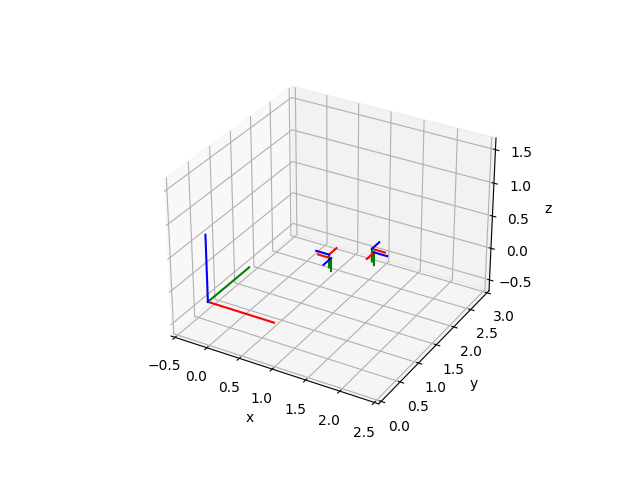

In [5]:
# function to plot a coordinate frame axis in red-green-blue (for x, y, z)
def coordframe(ax, T):
    """
       Parameters:
           ax: axes to plot on
           T:  3x4 or 4x4 matrix giving the homogeneous transform from the coordinate 
               frame to be plotted to the world frame. Note that the scale of the axes
               can be captured in T.
    """
    ax.plot3D([T[0,3], T[0,3]+T[0,0]], [T[1,3], T[1,3]+T[1,0]], [T[2,3], T[2,3]+T[2,0]], ',-r')
    ax.plot3D([T[0,3], T[0,3]+T[0,1]], [T[1,3], T[1,3]+T[1,1]], [T[2,3], T[2,3]+T[2,1]], ',-g')
    ax.plot3D([T[0,3], T[0,3]+T[0,2]], [T[1,3], T[1,3]+T[1,2]], [T[2,3], T[2,3]+T[2,2]], ',-b')
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal', xlabel='x', ylabel='y', zlabel='z')

coordframe(ax, T[0,:,:])
scalemat = np.vstack((np.hstack((0.2*np.identity(3), np.zeros((3,1)))),
                      np.array([0,0,0,1])))
coordframe(ax, T[4,:,:] @ CT[0, :,:] @ scalemat)
coordframe(ax, T[4,:,:] @ CT[1, :,:] @ scalemat)
coordframe(ax, T[4,:,:] @ CT[2, :,:] @ scalemat)
coordframe(ax, T[4,:,:] @ CT[3, :,:] @ scalemat)

ax.set_xlim([0, 2])
ax.set_ylim([0, 3])
ax.set_zlim([0, 1])
ax.set_aspect('equal')

plt.show()